### GWR and MGWR example
***
This is a basic example notebook demostrate  how to calibrate a GWR or an MGWR model.

#### Installation
`pip install mgwr`

In [1]:
#pip install mgwr

Load packages

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran

#MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

Load voting dataset

In [8]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2020.csv')

voting[['median_income']] = voting[['median_income']]/10000

In [9]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [10]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP').geometry.boundary

In [11]:
variable_names = ['sex_ratio', 'pct_black', 'pct_hisp',
                  'pct_bach', 'median_income','ln_pop_den']


y = shp_voting[['new_pct_dem']].values

X = shp_voting[variable_names].values

Often in GWR or MGWR, we suggest to standardize both the independent and the dependent variables. By standardizing, here it means we substract the mean and divided by the standardization.

The benefit of this approach is that the coefficients obtained become "unit-free," allowing for comparison of variable importance across variables and locations.

In [12]:
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

We need the coordinates to put into GWR.

In [13]:
coords = shp_voting[['proj_X', 'proj_Y']].values

#### Fit a GWR model in two steps
- Select the optimal bandwidths
- Use the optimal bandwidth to fit the GWR model
***
The default kernel is adaptive (# of nearest neighbors) bisquare.

In [18]:
gwr_selector = Sel_BW(coords, y, X)

gwr_bw = gwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  1219.0 , score:  4058.94
Bandwidth:  1938.0 , score:  4614.76
Bandwidth:  774.0 , score:  3557.79
Bandwidth:  499.0 , score:  3140.51
Bandwidth:  329.0 , score:  2802.09
Bandwidth:  224.0 , score:  2530.12
Bandwidth:  159.0 , score:  2375.52
Bandwidth:  119.0 , score:  2310.56
Bandwidth:  94.0 , score:  2291.48
Bandwidth:  79.0 , score:  2297.64
Bandwidth:  104.0 , score:  2296.46
Bandwidth:  89.0 , score:  2289.15
Bandwidth:  85.0 , score:  2289.31
Bandwidth:  91.0 , score:  2289.59
Bandwidth:  87.0 , score:  2291.76
Selected optimal bandwidth is: 89.0


Fit the model using the optimal bw

In [19]:
gwr_results = GWR(coords, y, X, bw=gwr_bw,name_x=variable_names).fit()

Summary of GWR outputs

In [20]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1213.006
Log-likelihood:                                                   -2945.693
AIC:                                                               5905.385
AICc:                                                              5907.432
BIC:                                                             -23679.220
R2:                                                                   0.609
Adj. R2:                                                              0.608

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The local estimates can be obtained from `gwr_results.params`, which returns you a n by p array where p is the number of predictors in the model (including intercept).

In [23]:
variable_names

['sex_ratio',
 'pct_black',
 'pct_hisp',
 'pct_bach',
 'median_income',
 'ln_pop_den']

In [24]:
gwr_results.params[:,4]

array([ 0.56501565,  0.61552673,  0.42141522, ..., -0.09090834,
        0.75477483,  0.39401467])

Text(0.5, 1.0, 'Coefficients of ln_pop_den')

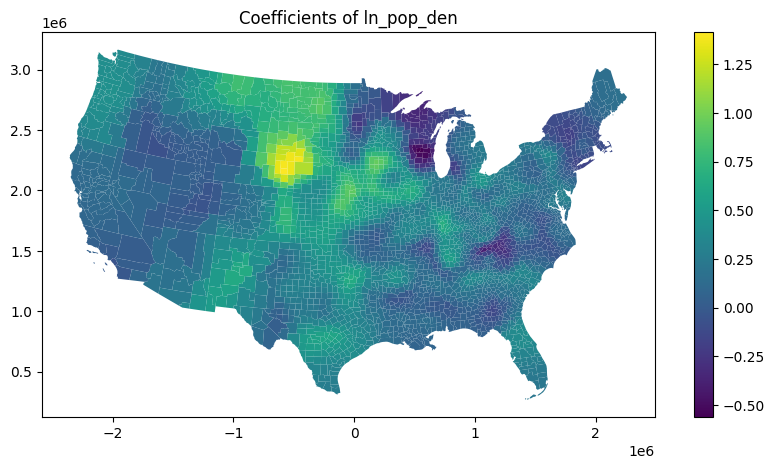

In [27]:
from matplotlib import colors

ax = shp_voting.plot(column=gwr_results.params[:,6],figsize=(10,5),legend=True, 
                     linewidth=0.0,aspect=1)

plt.title("Coefficients of ln_pop_den",fontsize=12)

Write some mapping codes to visualize the parameter estimate surfaces altogether. We need to join the GWR result with the county GeoDataFrame.

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False,figsize=(10, 10)):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    k = gwr_results.k
    
    fig, axs = plt.subplots(int(k/2)+1, 2, figsize=figsize)
    axs = axs.ravel()
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("bwr_r")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap=cmap,norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### Here are the maps of parameter estimates obtained from GWR. Each represent the spatial relationship between each predictor and PctBach.

- Positive (negative) relationships are shown in red (blue).
- Stronger (weaker) relationship has a darker (lighter) color.

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_19922/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


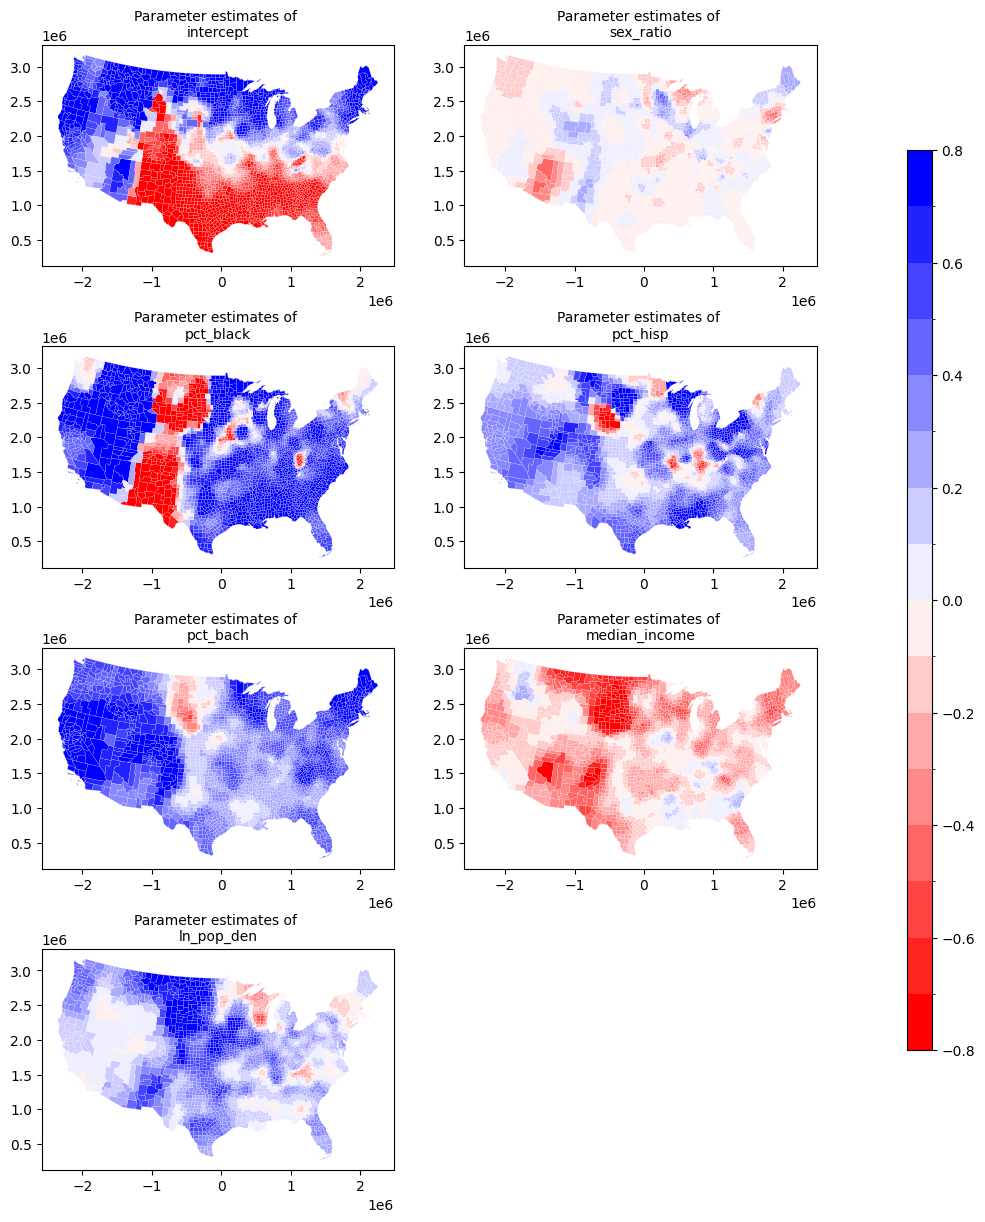

In [29]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15))

Now lets checkout the residuals of from the GWR model.

In [15]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(gwr_results.resid_response.reshape(-1), w)
residual_moran.I

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/2963299590.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


0.1142496644549166

Often, we observe that the residuals from the GWR model have much lower Moran's I values, indicating that spatial structure has been accounted for. The local intercept serves as an intrinsic contextual effect, indicating, for example, how much influence can be attributed to the "location" alone.



### GWR inference

Local coefficient significance

#### Here are the maps of **SIGNIFICANT (p<0.05)** parameter estimates. The significance test has been adjusted to account for the multiple testing issue (Bonferroni). 

Insinificant parameters are masked out in grey. 

This is done by the `result.filter_tvals()` in the `param_plots()` function.


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/3391375418.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


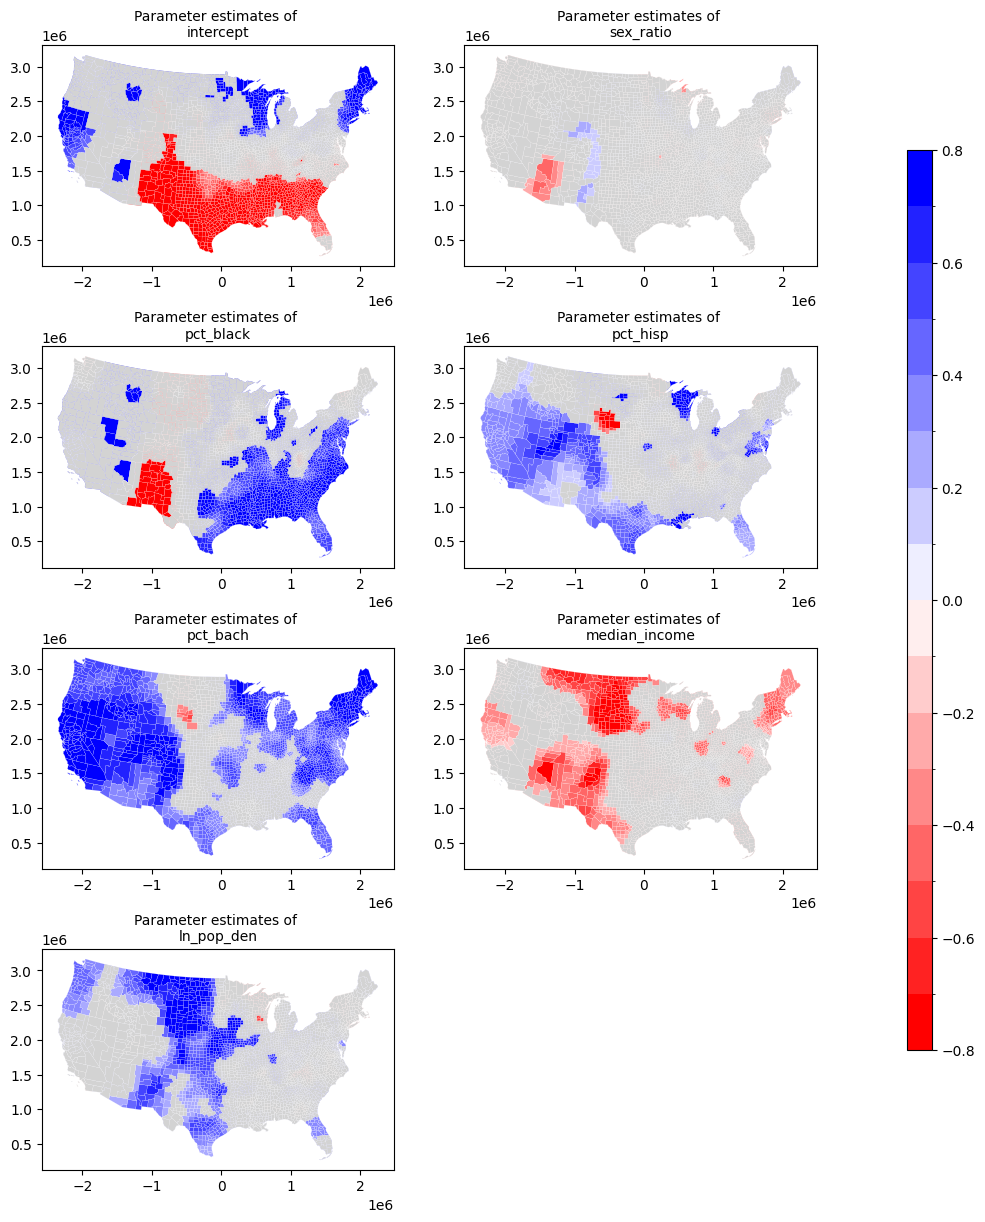

In [16]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

#### Fit an MGWR model in two steps
- Search for the optimal bandwidths
- Use the optimal bandwidths to fit the MGWR model
***

**Note**: MGWR will be slow when the data is beyond 5,000 records.

In [17]:
%%time
mgwr_selector = Sel_BW(coords, y, X,multi=True)
mgwr_bw = mgwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Current iteration: 1 ,SOC: 0.0054349
Bandwidths: 44.0, 142.0, 44.0, 44.0, 77.0, 48.0, 46.0
Current iteration: 2 ,SOC: 0.0026123
Bandwidths: 44.0, 293.0, 44.0, 54.0, 86.0, 46.0, 52.0
Current iteration: 3 ,SOC: 0.0017879
Bandwidths: 44.0, 569.0, 44.0, 77.0, 92.0, 44.0, 77.0
Current iteration: 4 ,SOC: 0.0013908
Bandwidths: 44.0, 736.0, 44.0, 103.0, 92.0, 44.0, 110.0
Current iteration: 5 ,SOC: 0.0011674
Bandwidths: 44.0, 870.0, 44.0, 128.0, 112.0, 44.0, 132.0
Current iteration: 6 ,SOC: 0.001013
Bandwidths: 44.0, 1292.0, 44.0, 157.0, 117.0, 44.0, 153.0
Current iteration: 7 ,SOC: 0.000908
Bandwidths: 44.0, 1459.0, 44.0, 225.0, 118.0, 44.0, 159.0
Current iteration: 8 ,SOC: 0.0007754
Bandwidths: 44.0, 1592.0, 44.0, 283.0, 118.0, 44.0, 171.0
Current iteration: 9 ,SOC: 0.0006401
Bandwidths: 44.0, 1677.0, 44.0, 318.0, 128.0, 44.0, 175.0
Current iteration: 10 ,SOC: 0.000536
Bandwidths: 44.0, 1677.0, 44.0, 370.0, 128.0, 44.0, 197.0
Current iteration: 11 ,SOC: 0.0004756
Bandwidths: 44.0, 1677.0, 44.

Current iteration: 87 ,SOC: 1.43e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 88 ,SOC: 1.4e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 89 ,SOC: 1.37e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 90 ,SOC: 1.35e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 91 ,SOC: 1.32e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 92 ,SOC: 1.29e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 93 ,SOC: 1.26e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 94 ,SOC: 1.23e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 95 ,SOC: 1.21e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 96 ,SOC: 1.18e-05
Bandwidths: 44.0, 1934.0, 44.0, 1275.0, 180.0, 44.0, 228.0
Current iteration: 97 ,SOC: 1.16e-05
Band

In [18]:
mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1213.006
Log-likelihood:                                                   -2945.693
AIC:                                                               5905.385
AICc:                                                              5907.432
BIC:                                                             -23679.220
R2:                                                                   0.609
Adj. R2:                                                              0.608

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [20]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(mgwr_results.resid_response.reshape(-1), w)
residual_moran.I

('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/3541487640.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


0.01835193713566798

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/3391375418.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


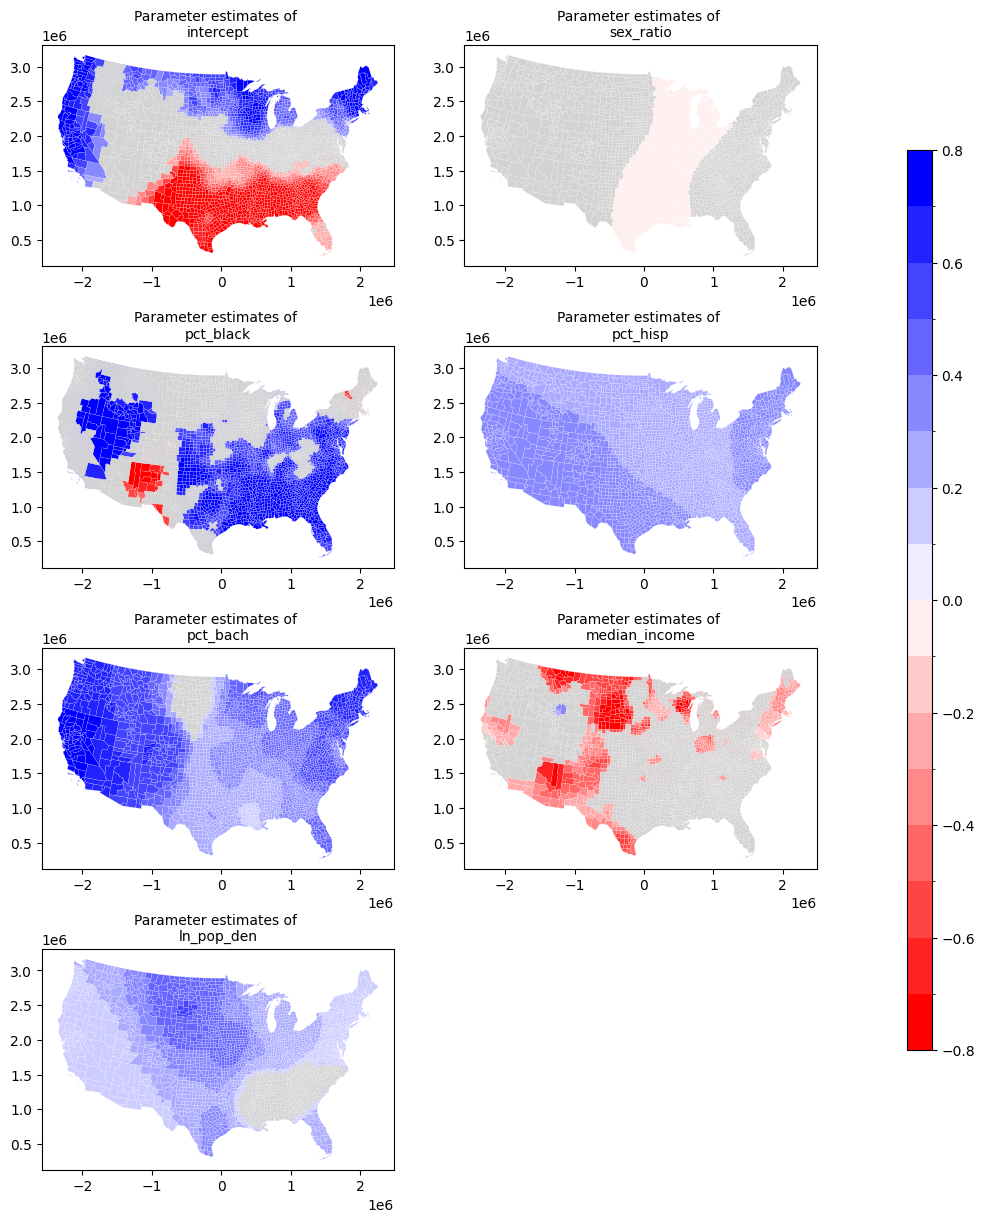

In [21]:
param_plots(mgwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

We can see that the relationships will vary at different spatial scales.

### OLS vs. GWR vs. MGWR

From the comparison, we can clearly see an advantage of MGWR over GWR by allowing the bandwidth to vary across covariates.

| Metric    | OLS    | GWR   | MGWR   |
| -----------  | ----------- | ----------- | ----------- |
| R2     | 0.609       | 0.920        | 0.928      |
| AICc    | 5907.4        | 2289.1        | 1802.7      |
| Moran's I of residuals    | 0.60      | 0.11       | 0.018       |
